## PCA

#### Short summary of notebook

Principal Component Analysis, PCA, is a mathematical technique used for dimensionality reduction. Its goal is to reduce the number of features whilst keeping most of the original information.

not used for: 
- nonlinear distributions,
- clustered distributions.

Why use PCA?
- **Reduces training time** — due to smaller dataset
- **Removes noise** — by keeping only what’s relevant
- **Makes visualization possible** — in cases where you have a maximum of 3 principal components

#### What are principal components?

Principal components form a set of linear independent vectors, pointing into the direction of the largest variance. The corresponding eigenvalue quantifies the amount of variance in that direction of the dataset.

To plot principal components, those eigenvectors can first be normalized and than scaled by the eigenvector (or its squareroot) to indicate the amount of variance (or the standard deviation) in that direction.


#### Pseudo Code

Step 1: Calculate the Correlation matrix data consisting of n dimensions. 
				The Correlation matrix will be of shape n*n.

Step 2: Calculate the Eigenvectors and Eigenvalues of this matrix.

Step 3: Take the first k-eigenvectors with the highest eigenvalues.

Step 4: Project the original dataset into these k eigenvectors resulting 
				in k dimensions where k ≤ n.

source: https://towardsdatascience.com/dimensionality-reduction-pca-versus-autoencoders-338fcaf3297d

Imports

In [50]:
import pandas as pd
import numpy as np
import os

In [51]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yaml 
from yaml.loader import UnsafeLoader
import os

import tensorflow as tf
import tensorflow_datasets as tfds

loading datasets

In [52]:
file_name = 'dummy_df.csv'
relative_path =   '/../data'

# get save path 
save_path = os.getcwd() +  relative_path # https://stackoverflow.com/questions/39125532/file-does-not-exist-in-jupyter-notebook
full_path = os.path.join(save_path, file_name)
assert  os.path.exists(full_path), f'Path {relative_path}/{file_name} does not exist'

# read via panda reader
df = pd.read_csv(full_path)
df.shape
print(df.head())
target_feature = 'out'

cols = list(df.columns)
print(cols)


         x1        x2  out
0  3.745401  6.981617    1
1  9.507143  5.360964    0
2  7.319939  3.095276    0
3  5.986585  8.137950    0
4  1.560186  6.847312    1
['x1', 'x2', 'out']


Standarize X in respect to its features, compute cov matrix & compute eigenvalues

In [53]:
# standarize the data respecting its features
from sklearn.preprocessing import StandardScaler

df = StandardScaler().fit_transform(df)
print("df scaled", df[:5])

# Compute the covariance matrix and store it into covar
features = df.T
#print("features", features[:5])

covar = np.cov(features)
print("covar", covar[:5])

#assert covar.shape == (5, 11)

# Compute the eigenvalues and eigenvectors and store them into eigenval and eigenvec
#       (Figure out a function to do this for you)
eigenval, eigenvec = np.linalg.eig(covar)
print(eigenval[:5])
print(eigenvec[:5])

#assert eigenval.shape == (11,)
#assert eigenvec.shape == (11, 11)
for ev in eigenvec: np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

df scaled [[-0.41563649  0.75807991  1.85061578]
 [ 1.51530965  0.18984392 -0.54036068]
 [ 0.78230693 -0.60455487 -0.54036068]
 [ 0.33545667  1.16351517 -0.54036068]
 [-1.14797267  0.71098954  1.85061578]]
covar [[ 1.00200401  0.01037495 -0.46812614]
 [ 0.01037495  1.00200401  0.50004595]
 [-0.46812614  0.50004595  1.00200401]]
[0.31183489 1.01235642 1.68182071]
[[ 0.48558076 -0.73003279 -0.48089859]
 [-0.51767761 -0.68341139  0.51474145]
 [ 0.70442971  0.00099811  0.70977305]]


(array([1.01235642, 1.01235642]),
 array([0.        , 0.66666667]),
 <matplotlib.lines.Line2D at 0x1ecb10ba2f0>)

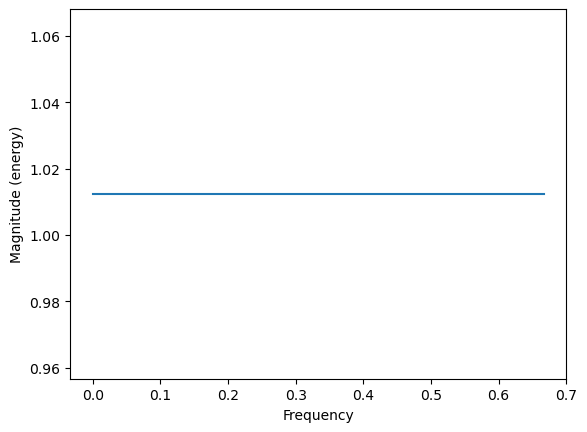

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

# sort eigenval by mag in descending order
eigenval[::-1].sort()

# plot eigenvalues
plt.magnitude_spectrum(eigenval) 

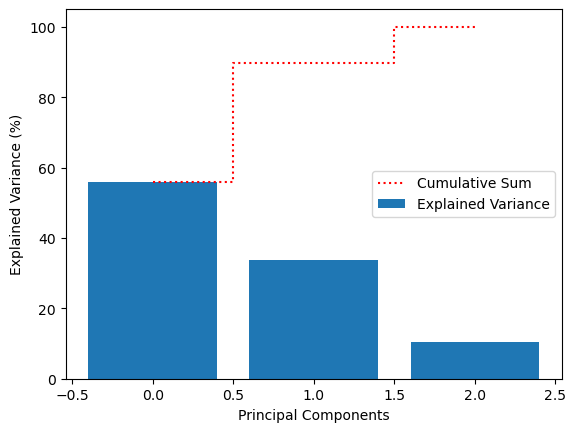

In [55]:
var_exp = [val*100/sum(eigenval) for val in eigenval]
cum_sum = np.cumsum(var_exp)

plt.bar(range(len(eigenval)), var_exp, label='Explained Variance')
plt.step(range(len(eigenval)), cum_sum, 'r:',
         where='mid', label='Cumulative Sum')
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Components')
plt.legend(loc='center right')


RangeIndex(start=0, stop=500, step=1)


Text(-18, -15, 'PC2')

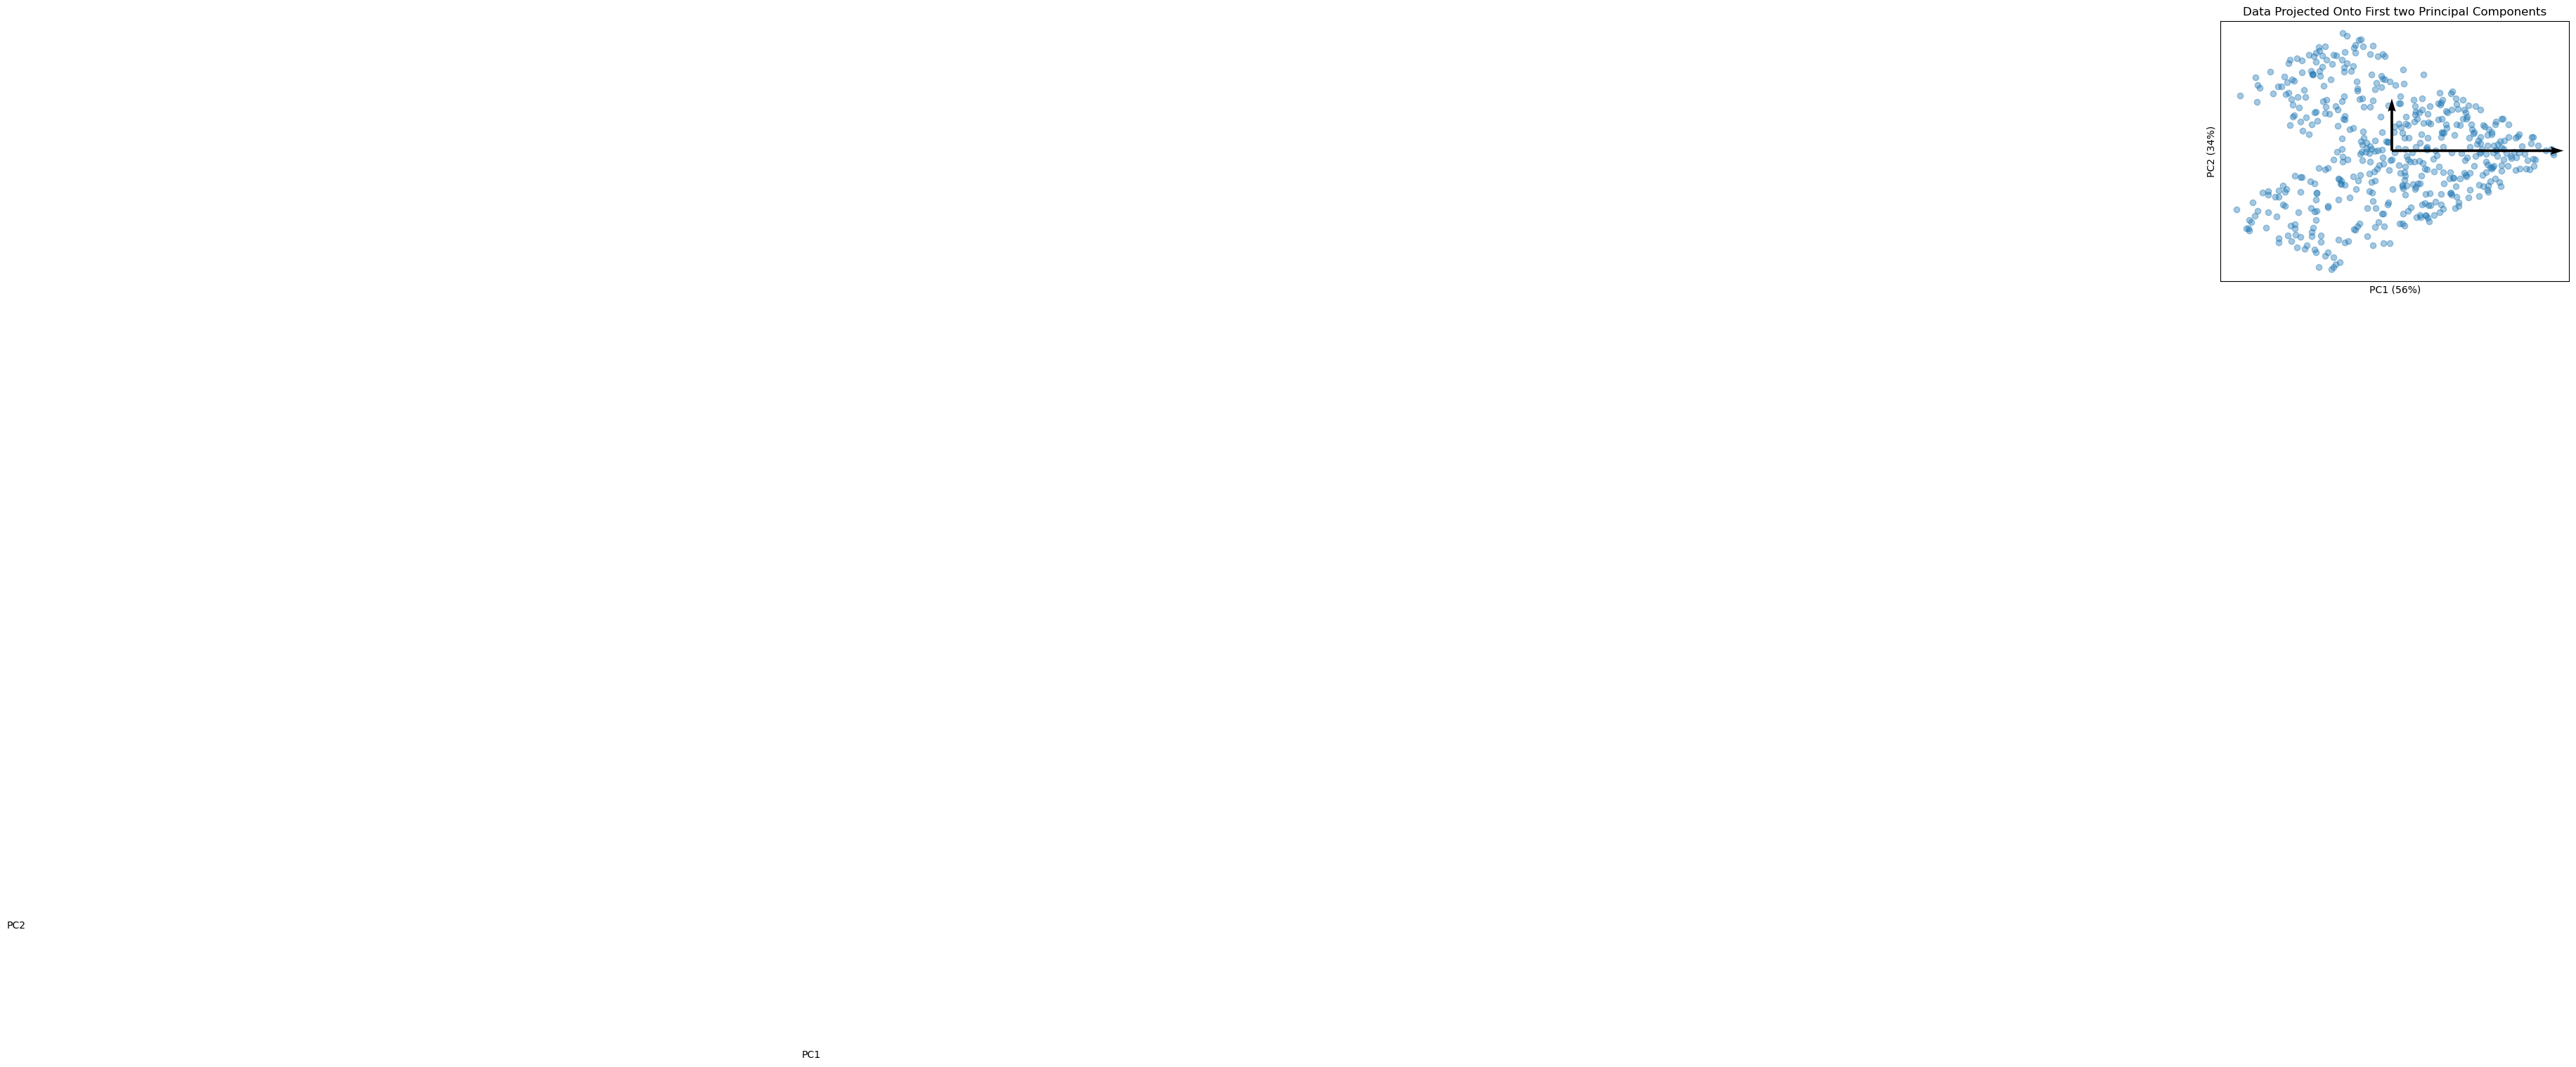

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt


projected_1 = df.dot(eigenvec.T[0])
projected_2 = df.dot(eigenvec.T[1])
proj = pd.DataFrame(projected_1, columns=["PC1"])
#proj["ID"] = proj.index 
proj["PC2"] = projected_2
print(proj.index) #  has 97 dpoints


# Plot projected data
plt.title('Data Projected Onto First two Principal Components')
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1 ({}%)'.format(round(var_exp[0])))
plt.ylabel('PC2 ({}%)'.format(round(var_exp[1])))
plt.scatter(proj["PC1"], proj["PC2"], alpha=.4) # accessing via PC? directly
# plt.scatter(proj[:,0], proj[:,1], alpha=.4) # throws error

# Plot the PC Vectors
# Project them and scale them by the standard deviation.
eigenvec_p = eigenvec.T @ eigenvec * np.sqrt(eigenval)
origin = np.mean(proj, axis=0)

plt.quiver(*origin, eigenvec_p[0,0], eigenvec_p[0,1], angles='xy', scale_units='xy', scale=1)
plt.quiver(*origin, eigenvec_p[1,0], eigenvec_p[1,1], angles='xy', scale_units='xy', scale=1)


plt.text(-12,-17.5, 'PC1')
plt.text(-18,-15, 'PC2')

eigenvec_s [[ 0.62972555 -0.73452924 -0.26854425]
 [-0.67135037 -0.68762069  0.28744284]
 [ 0.91353989  0.00100425  0.39635273]]


IndexError: index 3 is out of bounds for axis 0 with size 3

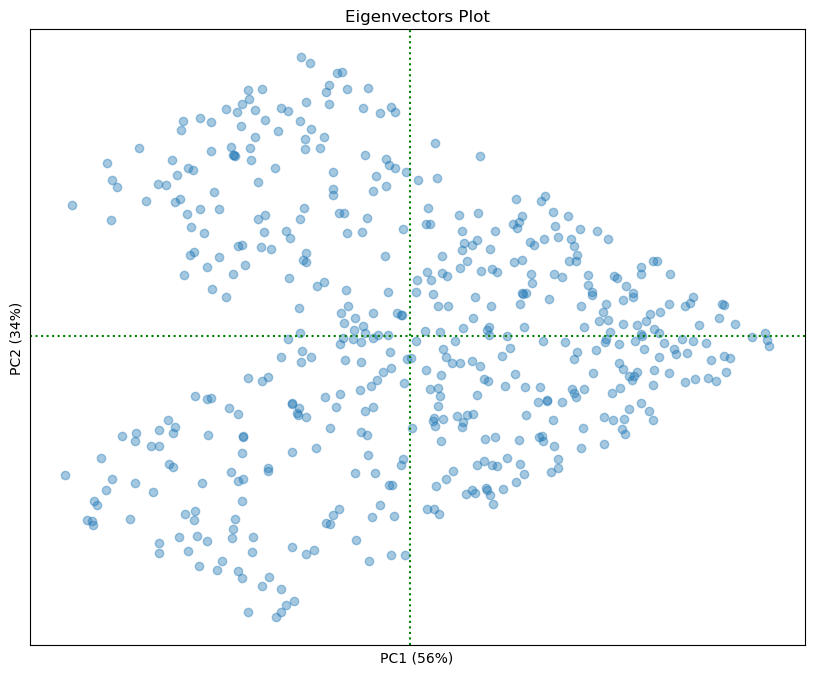

In [57]:
# same without error
# Set the plot

plt.figure(figsize=(10,8))

plt.title('Eigenvectors Plot')
plt.axhline(0, color='green', linestyle=':')
plt.axvline(0, color='green', linestyle=':')
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1 ({}%)'.format(round(var_exp[0])))
plt.ylabel('PC2 ({}%)'.format(round(var_exp[1])))


# plot centered projected data
proj = proj - np.mean(proj, axis=0)

plt.scatter(proj["PC1"], proj["PC2"], alpha=.4) # accessing via PC? directly

# scale eigenvectors
eigenvec_s = eigenvec * np.sqrt(eigenval)
print("eigenvec_s",eigenvec_s)


# find target feature vector
target_feature_vec = np.array([0, 0, eigenvec_s[:,:2][3][0]*5, eigenvec_s[:,:2][3][1]*5]) #hardcoded bc i know idx of target feature
print(target_feature_vec)
plt.arrow(target_feature_vec[0], target_feature_vec[1], target_feature_vec[2], target_feature_vec[3], alpha=.8, 
            color="green", 
            width=0.03, head_width=.2, label= cols[idx])  
# plot other vectors according to their influence 
for idx, eivec in enumerate(eigenvec_s[:,:2]):
    if cols[idx] == target_feature: #skip target feature
        continue
    other_vec = np.array([0, 0, eivec[0]*5, eivec[1]*5])
    target_feature_vec = target_feature_vec / np.linalg.norm(target_feature_vec)
    other_vec = other_vec / np.linalg.norm(other_vec)
    angle_rad = np.arccos(np.dot(target_feature_vec, other_vec))
    print(cols[idx])

    print(target_feature_vec)
    print(other_vec)
    print(angle_rad)
    
    angle_deg = np.degrees(angle_rad)
    print(angle_deg)
    if angle_deg > 90:
        plt.arrow(0, 0, eivec[0]*5, eivec[1]*5, alpha=.8, 
            color="red",#plt.get_cmap("hot")(idx), 
            width=0.03, head_width=.2, label= cols[idx])   
    else: 
        plt.arrow(0, 0, eivec[0]*5, eivec[1]*5, alpha=.8, 
            color="green",#plt.get_cmap("summer")(idx), 
            width=0.03, head_width=.2, label= cols[idx])   
plt.legend()

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

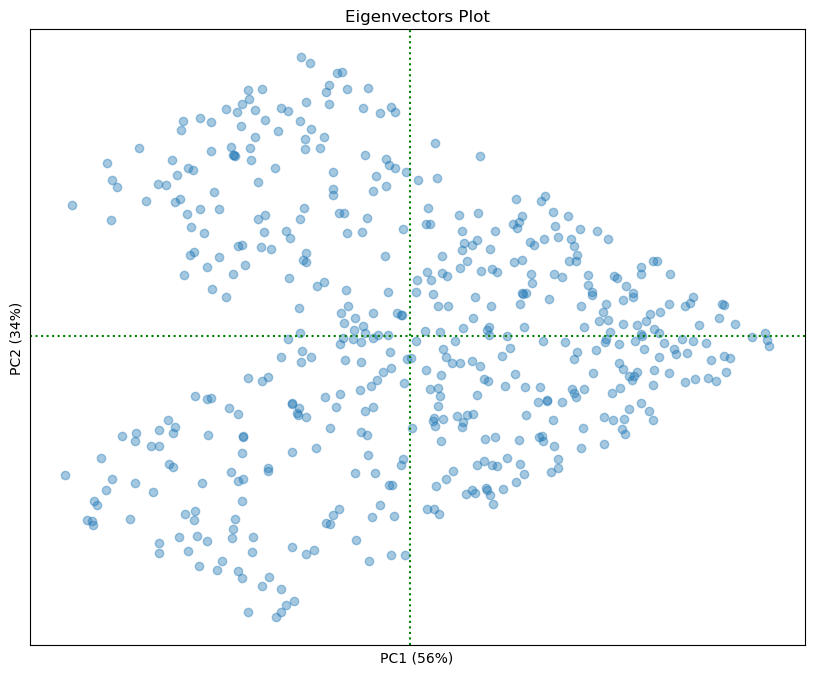

In [ ]:
# same without error
# Set the plot

plt.figure(figsize=(10,8))

plt.title('Eigenvectors Plot')
plt.axhline(0, color='green', linestyle=':')
plt.axvline(0, color='green', linestyle=':')
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1 ({}%)'.format(round(var_exp[0])))
plt.ylabel('PC2 ({}%)'.format(round(var_exp[1])))


# plot centered projected data
proj = proj - np.mean(proj, axis=0)

plt.scatter(proj["PC1"], proj["PC2"], alpha=.4) # accessing via PC? directly

# scale eigenvectors
eigenvec_s = eigenvec * np.sqrt(eigenval)

# Plot the eigenvector and add the labels
for idx, eivec in enumerate(eigenvec_s[:,:2]):
    plt.arrow(0, 0, eivec[0]*5, eivec[1]*5, alpha=.8, 
              color=plt.get_cmap('Set3')(idx), 
              width=0.03, head_width=.2, label= cols[idx])   

plt.legend()

plt.show()

## Conclusion